In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((480,640)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop((480,640)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Set data directory
data_dir = './output'

# Create datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Create dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Get dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=6, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=6, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the model
model = CNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Initialize variables to keep track of best accuracy and corresponding model weights
best_accuracy = 0.0
best_model_weights = None

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Check if current phase is validation and if current accuracy is better than the best accuracy
        if phase == 'val' and epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            # Save the model weights
            best_model_weights = model.state_dict()

# Save the best model weights
torch.save(best_model_weights, 'best_model_weights.pth')

print("Training complete!")


train Loss: 0.4967 Acc: 0.7742
val Loss: 0.3350 Acc: 0.8391
train Loss: 0.4054 Acc: 0.8243
val Loss: 0.2066 Acc: 0.9275
train Loss: 0.3646 Acc: 0.8392
val Loss: 0.2114 Acc: 0.9346
train Loss: 0.3321 Acc: 0.8485
val Loss: 0.1939 Acc: 0.9293
train Loss: 0.3229 Acc: 0.8459
val Loss: 0.1836 Acc: 0.9187
train Loss: 0.3028 Acc: 0.8573
val Loss: 0.1495 Acc: 0.9310
train Loss: 0.3056 Acc: 0.8557
val Loss: 0.1512 Acc: 0.9363
train Loss: 0.2879 Acc: 0.8658
val Loss: 0.1408 Acc: 0.9452
train Loss: 0.2769 Acc: 0.8674
val Loss: 0.1352 Acc: 0.9399
train Loss: 0.2787 Acc: 0.8702
val Loss: 0.1288 Acc: 0.9496
Training complete!


In [58]:
import torch
from torchvision import transforms
from PIL import Image

def predict_image(image_path, model, transform):
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Set model to evaluation mode
    model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = model(image)

    # Get predicted class index
    _, predicted = torch.max(outputs, 1)

    return predicted.item()  # Return predicted class index

# Load the trained model
model = CNN()  # Assuming CNN is your model class
model.load_state_dict(torch.load('best_model_weights.pth'))
model.eval()

# Define image transformation
transform = transforms.Compose([
        transforms.Resize((480,640)),
        #transforms.CenterCrop((480,640)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Test the model on a new image
image_path = './output/test/detached/Boiling-124-2-30355_bt124_mask_94.png'
#image_path= './output/test/attached/Img000862_bt78-75W_mask_1.png'
image_path ='./mask_10.png'# Replace with the path to your image

predicted_class = predict_image(image_path, model, transform)
print("Predicted class index:", predicted_class)


Predicted class index: 0


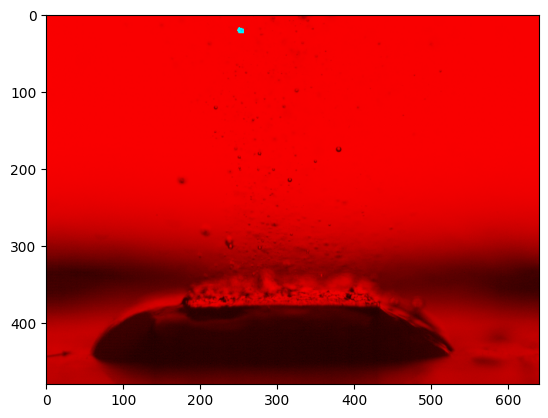

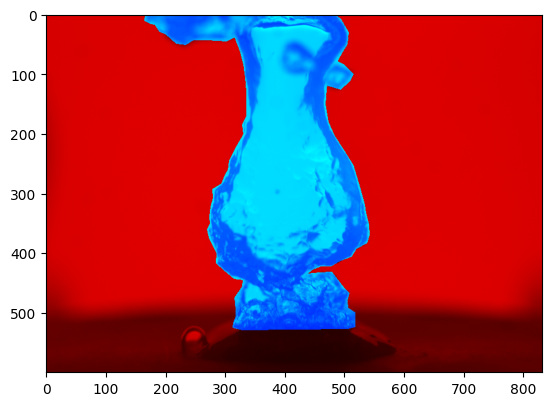

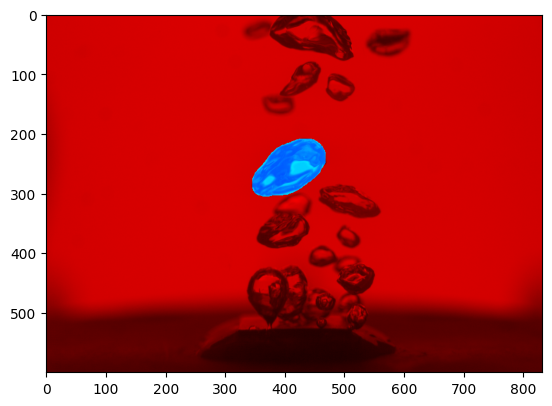

In [54]:
import matplotlib.pyplot as plt
image_path = './output/test/detached/Boiling-124-2-30355_bt124_mask_94.png'
plt.imshow(Image.open(image_path))
plt.show()
image_path= './output/test/attached/Img000862_bt78-75W_mask_1.png'
plt.imshow(Image.open(image_path))
plt.show()
image_path ='./mask_0.png'
plt.imshow(Image.open(image_path))
plt.show()

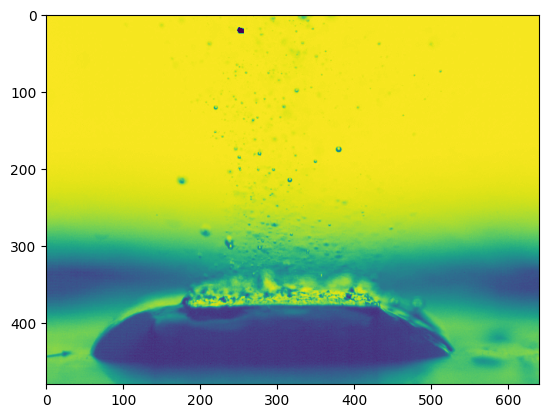

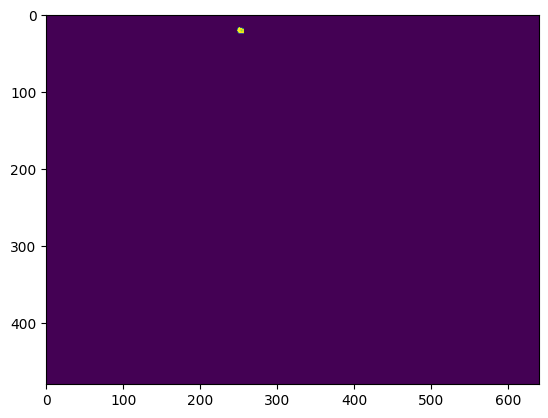

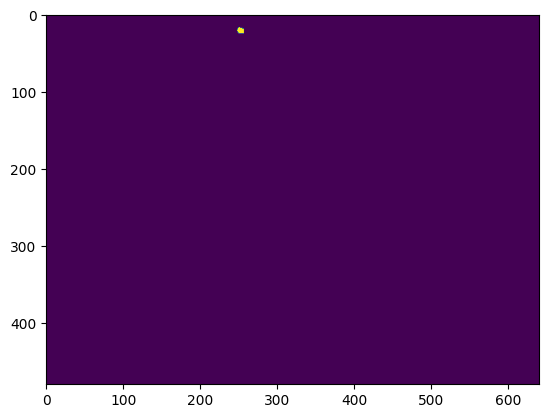

252 250 255


In [48]:
import numpy as np
image_path = './output/test/detached/Boiling-124-2-30355_bt124_mask_94.png'

plt.imshow(np.array(Image.open(image_path))[:,:,0])
plt.show()
plt.imshow(np.array(Image.open(image_path))[:,:,1])
plt.show()
plt.imshow(np.array(Image.open(image_path))[:,:,2])
plt.show()
print(np.amax(np.array(Image.open(image_path))[:,:,0]),
     np.amax(np.array(Image.open(image_path))[:,:,1]),
     np.amax(np.array(Image.open(image_path))[:,:,2]))

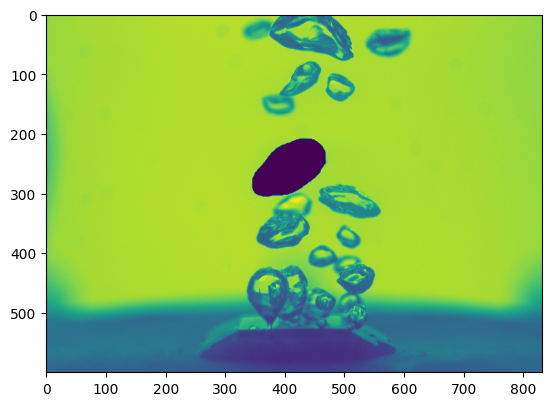

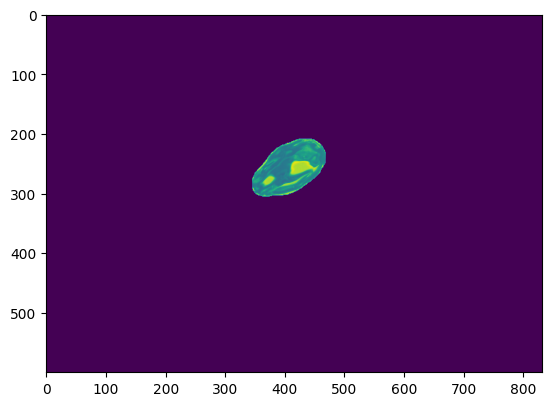

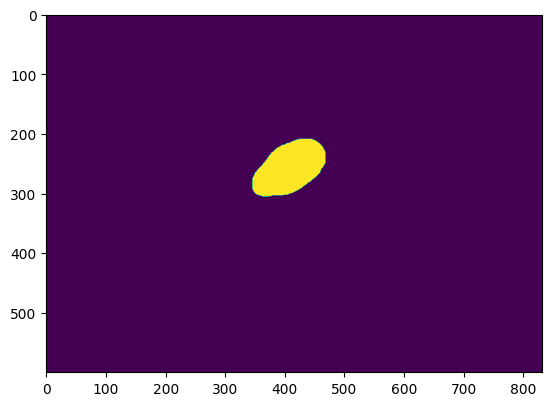

244 236 1


In [50]:
image_path ='./mask_0.png'
plt.imshow(np.array(Image.open(image_path))[:,:,0])
plt.show()
plt.imshow(np.array(Image.open(image_path))[:,:,1])
plt.show()
plt.imshow(np.array(Image.open(image_path))[:,:,2])
plt.show()
print(np.amax(np.array(Image.open(image_path))[:,:,0]),
     np.amax(np.array(Image.open(image_path))[:,:,1]),
     np.amax(np.array(Image.open(image_path))[:,:,2]))

In [51]:
np.array(Image.open(image_path))[:,:,2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)